In [1]:
base = "https://datadownload-production.s3.amazonaws.com"
y2017 = "GMW_v3_2017.zip"
y2020 = "GMW_v3_2020.zip"
india = [68.176645,  7.965535, 97.402561, 35.494010]

In [2]:
import geopandas as gpd
gmw2017_india = gpd.read_file( f"/vsizip/vsicurl/{base}/{y2017}", bbox=india)
gmw2020_india = gpd.read_file( f"/vsizip/vsicurl/{base}/{y2020}", bbox=india)


In [3]:
gmw2020_india

,PXLVAL,geometry
0,1,"POLYGON ((80.01089 8.99578, 80.01111 8.99578, ..."
1,1,"POLYGON ((80.01222 8.99511, 80.01267 8.99511, ..."
2,1,"POLYGON ((80.01356 8.99511, 80.01378 8.99511, ..."
3,1,"POLYGON ((80.92733 8.99356, 80.92756 8.99356, ..."
4,1,"POLYGON ((80.92644 8.99267, 80.92778 8.99267, ..."
...,...,...
96142,1,"POLYGON ((95.20711 16.05156, 95.20756 16.05156..."
96143,1,"POLYGON ((95.23400 16.00222, 95.23422 16.00222..."
96144,1,"POLYGON ((95.23711 16.00022, 95.23756 16.00022..."
96145,1,"POLYGON ((95.66089 16.00022, 95.66178 16.00022..."


In [4]:
import os
#os.environ["AWS_ACCESS_KEY_ID"]="<SET_SECURELY_OUTSIDE_SCRIPT>"
#os.environ["AWS_SECRET_ACCESS_KEY"]="<SET_SECURELY_OUTSIDE_SCRIPT>"
os.environ["AWS_S3_ENDPOINT"]="minio.carlboettiger.info"
os.environ["AWS_VIRTUAL_HOSTING"]="FALSE"
os.environ["CPL_VSIL_USE_TEMP_FILE_FOR_RANDOM_WRITE"]="YES"

In [5]:
# Works as long as access/secret keys are set
# gmw2020_india.to_file("/vsis3/biodiversity/mangroves/GMW2020_india.fgb", driver = "FlatGeobuf")



In [6]:
import pandas as pd
import planetary_computer
import pystac_client
import stackstac
from geogif import gif

In [7]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(collections=["io-biodiversity"], bbox=india)

items = list(search.items())

In [8]:
stack = (
    stackstac.stack(items, bounds_latlon=india, assets=["data"], resolution=0.1)
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy()
    )
    .sortby("time")
)
stack.name = "Biodiversity Intactness"
stack


/home/rstudio/.local/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'Biodiversity Intactness' (time: 92, band: 1, y: 276, x: 294)>
dask.array<getitem, shape=(92, 1, 276, 294), dtype=float64, chunksize=(1, 1, 276, 294), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time            (time) datetime64[ns] 2017-01-01 2017-01-01 ... 2020-01-01
    id              (time) <U49 'bii_2017_41.9239854959007_92.81475852596219_...
  * band            (band) <U4 'data'
  * x               (x) float64 68.1 68.2 68.3 68.4 68.5 ... 97.1 97.2 97.3 97.4
  * y               (y) float64 35.5 35.4 35.3 35.2 35.1 ... 8.4 8.3 8.2 8.1 8.0
    end_datetime    (time) <U20 '2017-12-31T23:59:59Z' ... '2020-12-31T23:59:...
    ...              ...
    start_datetime  (time) <U20 '2017-01-01T00:00:00Z' ... '2020-01-01T00:00:...
    description     <U54 'Terrestrial biodiversity intactness at 100m resolut...
    raster:bands    object {'sampling': 'area', 'data_type': 'float32', 'spat...
    version         <U2 'v1'
    title           <U23 'Biodiversity Intactness'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(68.10000000000001, 7.9, 97.5, ...
    crs:         epsg:4326
    transform:   | 0.10, 0.00, 68.10|\n| 0.00,-0.10, 35.50|\n| 0.00, 0.00, 1.00|
    resolution:  0.1

In [9]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = stack.squeeze().compute()


[########################################] | 100% Completed | 289.66 s


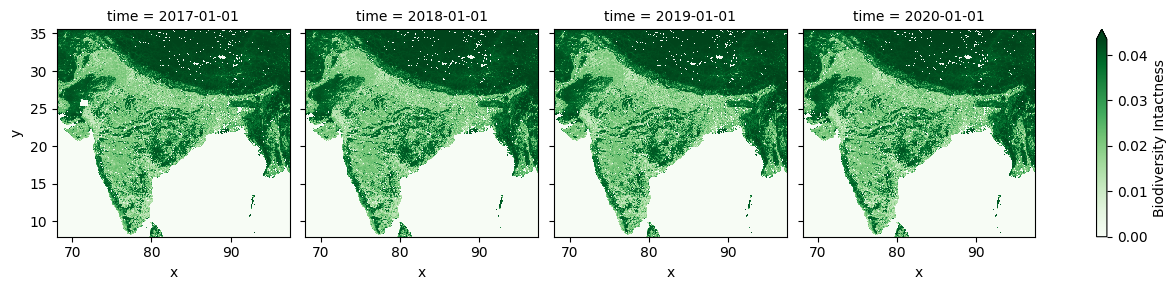

In [11]:
bii = data.groupby("time").mean(dim="time")
bii.plot(col="time", cmap="Greens", robust=True)


In [18]:
import rioxarray as rxr
#bii.rio.to_raster("/vsis3/biodiversity/mangroves/BII_india.tif")
bii.rio.to_raster("/vsis3/shared-data/BII_india.tif")


